# Problem adult-income

Zbiorem jest baza danych ludzi i z podstawowymi informacjami.
https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names

Celem jest predykcja czy dana osoba osiagnie przychód na poziomie ponad $50.000 rocznie.
Jest to zadanie na klasyfikacje binarną

In [1]:
import pandas as pd
import numpy as np

# metryka sukcesu
from sklearn.metrics import accuracy_score

# walidacja wyniku
from sklearn.model_selection import train_test_split

# modele
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# wizualizacja
import seaborn as sns
import matplotlib.pyplot as plt
# żeby otwierało się w notebooku a nie w nowo otwartym oknie
%matplotlib inline


#### Import danych

In [2]:
train = pd.read_hdf('input/train.adult.h5')

#### Poznanie zbioru danych

In [156]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32561 entries, 0 to 32560
Data columns (total 27 columns):
Age                          32561 non-null int8
Workclass                    32561 non-null object
fnlwgt                       32561 non-null int64
Education                    32561 non-null object
Education-Num                32561 non-null int64
Martial Status               32561 non-null object
Occupation                   32561 non-null object
Relationship                 32561 non-null object
Race                         32561 non-null object
Sex                          32561 non-null bool
Capital Gain                 32561 non-null int16
Capital Loss                 32561 non-null int16
Hours per week               32561 non-null int8
Country                      32561 non-null object
Target                       32561 non-null object
Target_cat                   32561 non-null int8
Workclass_cat                32561 non-null int64
Education_cat                32561 no

In [4]:
train.head()

,Age,Workclass,fnlwgt,Education,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,True,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,True,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,True,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,True,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,False,0,0,40,Cuba,<=50K


In [45]:
train.describe()

,Age,fnlwgt,Education-Num,Capital Gain,Capital Loss,Hours per week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,423.516600,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,3363.342471,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,-31441.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,27828.000000,4356.000000,99.000000


Sprawadzam wstępnie czy istnieje istotna korelacja między cechami

In [13]:
train.corr()

,Age,fnlwgt,Education-Num,Sex,Capital Gain,Capital Loss,Hours per week
Age,1.000000,-0.076646,0.036527,0.088832,0.064301,0.057775,0.068756
fnlwgt,-0.076646,1.000000,-0.043195,0.026858,-0.007000,-0.010252,-0.018768
Education-Num,0.036527,-0.043195,1.000000,0.012280,0.062300,0.079923,0.148123
Sex,0.088832,0.026858,0.012280,1.000000,0.028219,0.045567,0.229309
Capital Gain,0.064301,-0.007000,0.062300,0.028219,1.000000,-0.027282,0.031964
Capital Loss,0.057775,-0.010252,0.079923,0.045567,-0.027282,1.000000,0.054256
Hours per week,0.068756,-0.018768,0.148123,0.229309,0.031964,0.054256,1.000000



#### Sprawdzeniew zbiorze sa pustki, duplikaty, ewentualna zamiana formatu danych (int,object,etc)


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32561 entries, 0 to 32560
Data columns (total 15 columns):
Age               32561 non-null int8
Workclass         32561 non-null object
fnlwgt            32561 non-null int64
Education         32561 non-null object
Education-Num     32561 non-null int64
Martial Status    32561 non-null object
Occupation        32561 non-null object
Relationship      32561 non-null object
Race              32561 non-null object
Sex               32561 non-null bool
Capital Gain      32561 non-null int16
Capital Loss      32561 non-null int16
Hours per week    32561 non-null int8
Country           32561 non-null object
Target            32561 non-null object
dtypes: bool(1), int16(2), int64(2), int8(2), object(8)
memory usage: 2.9+ MB


In [8]:
def check_missing():
    for column in train.columns:
        missing = column, train[column].isnull().sum()
        if missing[1] == 0: continue

        print(missing)
        
check_missing()

Jak widac sa brakujace dane, wiec skorzystam z funkcji w pandas `fillna()`, która wypełnia wszystkie brakujące wartości.
Decyduje sie wypelnic brakujace luki liczba -1, bo 0 moze wystepowac czesto i pozniej ciezko odroznic prawdziwe dane od tych wypelnionych przeze mnie:

In [6]:
train = train.fillna(-1)

Ze względu na to, że model oczekuję na reprezentację liczbową zamiast słowną, trzeba stworzyc nowa kolumne dla zmiennej docelowej (Target).

Kolumna Target jest tekstowa (`<=50K`) i trzeba ja zamienic do klasy binarnej.
Cel to okreslic czy osoba bedzie zarabiala wiecej niz $50.000 rocznie wiec kolumna bedzie odpowiedza (`0,1`) na warunek `train['Target'] != '<=50K'`

In [16]:
train['Target_cat'] = (train['Target'] != '<=50K').astype('int8')

#### Metryka sukcesu



W tym problemie chodzi o klasyfikacje (binarną) więc decyduje sie na dokładność (`accuracy`). Nie jest to idealna miara, ale w celach edukacyjnych jest ok. W zależnosci od wymagań biznesu, ten parametr moze byc inny.


#### Użycie prostego modelu

Zaczynam od całkiem najprotszego modelu, który patrzy tylko na zmienna docelowa, czyli na to czy dana osoba zarabia ponizej czy powyzej $50.000 rocznie. 
Robie to po to, zeby miec juz pierwszy wynik, ktory bedzie moim "poziomem zero" z ktorego startuje.

In [89]:
y = train['Target_cat']
X = train[['Age']]

Za pomoca funkcji `train_test_split` rodzielam zbior danych na zbior treningowy i testowy

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

print("Train:", X_train.shape, y_train.shape)
print("Test:", X_test.shape, y_test.shape)

Train: (22792, 1) (22792,)
Test: (9769, 1) (9769,)


In [39]:
model = DummyClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(accuracy_score(y_test, y_pred))

0.636093765994


W celu łatwiejszego testowania i bardziej przejrzystego kodu, tworzę funkcję:

In [40]:
def train_and_predict(model, X, y, test_size=0.3):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    model.fit(X_train, y_train)    
    y_pred = model.predict(X_test) 

    return accuracy_score(y_test, y_pred)

#### Logistic Regression

Biorę troche bardziej zaawansowany, liniowy model.

W odróżnieniu od `DummyClassifier`, będzie już patrzył na zmienne.

In [98]:
train_and_predict(LogisticRegression(),X,y,test_size=0.33)

0.74613573548981471

Wynik jest znacznie lepszy, mimo że model wział pod uwage tylko **jedną** wcześniej zadeklarowaną zmienną (wiek):

`X = train[['Age']]`

## Feature engineering, czyli generowanie cech

Model oczekuje liczb, dlatego sprawdzam czy wszystkie kolumny w zbiorze danych są typu liczbowego (*int*)

In [123]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32561 entries, 0 to 32560
Data columns (total 27 columns):
Age                          32561 non-null int8
Workclass                    32561 non-null object
fnlwgt                       32561 non-null int64
Education                    32561 non-null object
Education-Num                32561 non-null int64
Martial Status               32561 non-null object
Occupation                   32561 non-null object
Relationship                 32561 non-null object
Race                         32561 non-null object
Sex                          32561 non-null bool
Capital Gain                 32561 non-null int16
Capital Loss                 32561 non-null int16
Hours per week               32561 non-null int8
Country                      32561 non-null object
Target                       32561 non-null object
Target_cat                   32561 non-null int8
Workclass_cat                32561 non-null int64
Education_cat                32561 no

Widac ze kolumny sa nie tylko typu liczbowego, ale tez kategorialne (zaznaczone jako *object*)

Zamieniam dane kategorialne na liczby, zeby móc wytrenować model.

***Label encoding***

W tym celu uzyje funkcji z pandas `.factorize()` zeby pobrać pierwszy element (drugi jest label, a nam jest potrzebne tylko ID).


In [35]:
#pd.factorize( train['Workclass'] )[0]

Sprawdzam które dokładnie kolumny są typu `object`

In [11]:
train.select_dtypes(include=[np.object]).columns

Index(['Workclass', 'Education', 'Martial Status', 'Occupation',
       'Relationship', 'Race', 'Country', 'Target'],
      dtype='object')

Dla każdej z tych kolumn, tworze nową (żeby nie nadpisać danych) w formacie liczbowym z dopiskiem `_cat`

In [12]:
cat_feats = train.select_dtypes(include=[np.object]).columns

for cat_feat in cat_feats:
    train['{0}_cat'.format(cat_feat)] = pd.factorize( train[cat_feat] )[0]

Dodaje nowo powstałe kolumny do nowej zmiennej po to żeby móc ją wykorzystac w modelu:

In [82]:
feats = train.select_dtypes(include=[np.int8,np.int16,np.int64,np.bool]).columns.values
feats = feats[feats != "Target_cat"]

In [223]:
X = train[ feats ]

Sprawdzam ponownie wynik modelu `LogisticRegression` po wczytaniu wszystkich cech

In [203]:
train_and_predict(LogisticRegression(),X,y,test_size=0.3)

0.76282116900399222

Wynik jest jest już tylko troche lepszy.


Spróbuje teraz dodać kilka własnych cech, bazując na tych które już są.

In [227]:
# biały mąż
train['white_hus'] = train.apply(lambda row: row['Relationship'] == 'Husband' and row['Race'] == 'White', axis=1).astype('int8')

In [228]:
# mezczyzna o zawodzie Exec-managerial lub Prof-specialty
train['man_manager_specialist'] = train.apply(lambda row: row['Sex'] == 'True' and row['Occupation'] == 'exec-managerial' or row['Occupation'] == 'Prof-specialty', axis=1).astype('int8')

In [229]:
# osoby z wyksztalceniem wyzszym z dobrze rozwinietych krajow
degree = ['Bachelors', 'Masters', 'Doctorate']
top_countries = ['United-States' ,'England', 'Canada', 'Germany', 'Japan', 'China', 'Italy', 'Ireland', 'France']
train['higher_degree_top_country'] = train.apply(lambda row: row['Education'] in degree and row['Country'] in top_countries, axis=1).astype('int8')


In [230]:
# wiek dzielę na klasy
train['wiek_klasa'] = pd.cut(train['Age'],5,labels=[0,1,2,3,4]).astype('int8')

Wciągam nowo powstałe cechy do zmiennej i ponownie sprawdzam wynik

In [245]:
feats = train.select_dtypes(include=[np.int8,np.int16,np.int64,np.bool]).columns.values
feats = feats[feats != "Target_cat"]

In [267]:
train_and_predict(LogisticRegression(), X, y, test_size=0.33)

0.79015252328795171

In [ ]:
Wynik jest jeszcze odrobinę lepszy.

#### Drzewo decyzyjne

Użyje troche bardziej zaawansowanego modelu `DecisionTreeClassifier`

In [273]:
train_and_predict(DecisionTreeClassifier(), X, y, test_size=0.33)

0.80878288463507009

Jeszcze lepszy wynik...

Teraz sprawdzam czy model się nie przeuczył

In [274]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

In [300]:
def plot_learning_curve(model, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    
    plt.figure(figsize=(12,8))
    plt.title(title)
    if ylim is not None:plt.ylim(*ylim)

    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

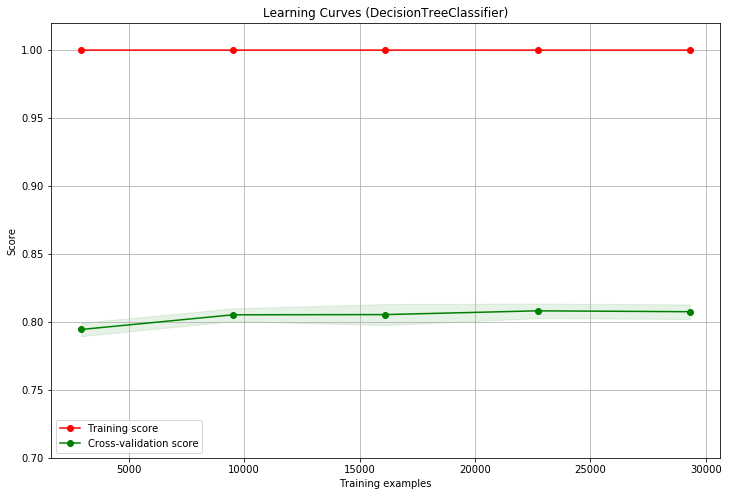

In [301]:
plt = plot_learning_curve(DecisionTreeClassifier(), "Learning Curves (DecisionTreeClassifier)", X, y, ylim=(0.7, 1.02), cv=10, n_jobs=4)
plt.show()



Czerwona kreska, niezależnie od ilości danych treningowych, cały czas osiąga wartość 1 co oznacza, że model się przeuczył. Różnica między wynikiem treningowym a walidacją jest zbyt duża.

Decyduje się na ograniczenie głębokości drzewa i ustawiam parametr `max_depth = 10` po to by ponownie sprawdzić wykres



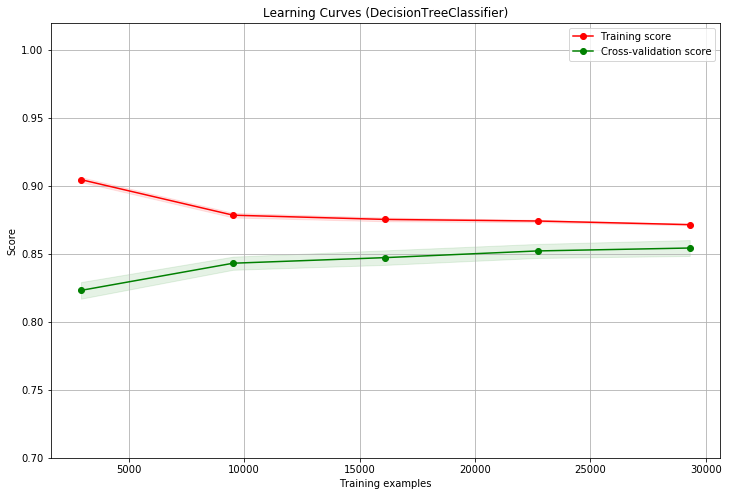

In [305]:
plt = plot_learning_curve(DecisionTreeClassifier(max_depth=10), "Learning Curves (DecisionTreeClassifier)", X, y, ylim=(0.7, 1.02), cv=10, n_jobs=4)
plt.show()

Wraz z ilością danych treningowych, model (na zielono) osiąga coraz wyższą wartość. Różnica wartości jest zdecydowanie mniejsza, linie zbiegają się, co oznacza że problem over-fittingu został rozwiązany.